#### Import packages

In [1]:
import os
import pandas as pd
from torchvision.io import read_image
from PIL import Image, ImageDraw
from torch.utils.data import Dataset, WeightedRandomSampler, DataLoader
from torchvision import transforms, models
from tqdm.auto import tqdm
import torch
import numpy as np
import cv2
import warnings
import matplotlib.pyplot as plt

/Users/catarina/Desktop/DataScience/DataScienceProjects/FruitsDetection/fruits-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Create a customized dataset class

Customize a dataset class to import and transform your own data, so it'll be ready to use by the model. <br> In this case we want to import the images and labels in `fruits-detection/test/`

In [2]:
import random

class MultiLabelDataset(Dataset):
    def __init__(self, 
                 img_root='Fruits-detection', 
                 sub_root='train', 
                 img_dir='images',
                 img_labels='labels',
                 train=True,
                 num_images=50):  # Added parameter for the number of images per batch
        self.img_root = img_root
        self.sub_root = sub_root
        self.img_dir = img_dir
        self.img_labels = img_labels
        self.train = train
        self.num_images = num_images  # Store the number of images per batch
        
        # Define class names
        self.class_names = {0: 'apple', 1: 'banana', 2: 'grape', 3: 'orange', 4: 'pineapple', 5: 'watermelon'}

        # Initialize an array of zeros for multi-label encoding
        self.multi_label_labels = []

        # Get labels
        dfs = []
        self.labels_path = os.path.join(self.img_root, self.sub_root, self.img_labels)
        for file in os.listdir(self.labels_path):
            if file.endswith(".txt"):
                file_path = os.path.join(self.labels_path, file)
                df = pd.read_csv(file_path, delimiter=" ", names=["label", "coordinate_1", "coordinate_2", "coordinate_3", "coordinate_4"])  # Adjust column names as needed
                df["filename"] = os.path.splitext(file)[0] + '.jpg'
                df["class_name"] = df["label"].map(self.class_names)
                dfs.append(df)

        self.final_df = pd.concat(dfs, ignore_index=True)
        
        # Get class-wise indices to randomly select images
        self.class_indices = {class_name: self.final_df[self.final_df['class_name'] == class_name].index.tolist() for class_name in self.class_names.values()}
                
        # Initialize an empty list to store multi-label encoded labels
        multi_label_labels_dict = {}

        # Randomly select images for each class
        selected_indices = []
        for class_name, indices in self.class_indices.items():
            selected_indices.extend(random.sample(indices, min(len(indices), self.num_images)))

        # Iterate over the selected indices
        for idx in selected_indices:
            filename = self.final_df.loc[idx, 'filename']
            labels = set(self.final_df[self.final_df['filename'] == filename]['label'].tolist()) # If there are multiple fruits in an image
            
            # Initialize an array of zeros for multi-label encoding
            multi_label_labels = [0] * len(self.class_names)
            
            # Set the corresponding indices to 1 for each label
            for label in labels:
                multi_label_labels[label] = 1

            # Append the multi-label encoded labels to the dictionary
            multi_label_labels_dict[filename] = [multi_label_labels]
        
        # Convert the dictionary of lists to a list of arrays
        multi_label_labels_list = [torch.tensor(labels) for labels in multi_label_labels_dict.values()]

        # Stack the padded tensors to create a single tensor
        self.multi_label_labels_tensor = torch.stack(multi_label_labels_list)

        # Get images
        self.imgs_path = os.path.join(self.img_root, self.sub_root, self.img_dir)
        image_names = self.final_df.iloc[selected_indices]['filename'].tolist()
        self.images = []
        self.images_path = []
        for img_name in tqdm(image_names):
            image_path = os.path.join(self.imgs_path, img_name)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            self.images_path.append(image_path)
            self.images.append(image)
        
        # Define transformations
        if self.train:
            self.transform = transforms.Compose([
                transforms.RandomResizedCrop(240),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
    
    def get_image_path(self, idx):
        img_path = self.images_path[idx] 
        return img_path
    
    def get_labels(self, idx):
        return self.multi_label_labels_tensor[idx]
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.multi_label_labels_tensor[idx]
        
        # Apply transformations
        transformed_image = self.transform(Image.fromarray(image))
        
        return transformed_image, label

Instantiate a training dataset and a validation dataset

In [3]:
train_dataset = MultiLabelDataset(num_images=200)
val_dataset = MultiLabelDataset(sub_root='valid', num_images=50, train=False)

100%|██████████| 300/300 [00:00<00:00, 446.96it/s]


Check instantiation content

In [4]:
# length check
print(len(train_dataset))
print(len(val_dataset))

1200
300


Print an image from the training dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


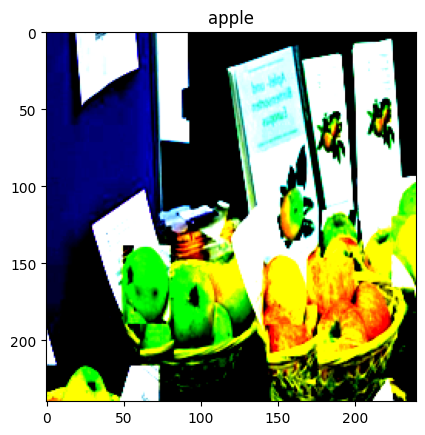

Labels: tensor([[1, 0, 0, 0, 0, 0]])


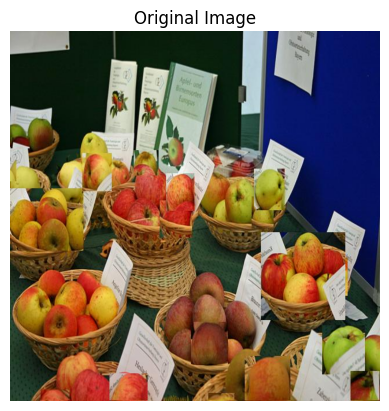

In [5]:
for i, data in enumerate(train_dataset):
    images, labels = data[0], data[1]
    class_index = torch.argmax(labels[0])  # Get index of the first non-zero label
    class_name = train_dataset.class_names[class_index.item()]  # Convert index to class name
    plt.title(class_name)
    plt.imshow(np.transpose(images.numpy(), (1, 2, 0)))  # Transpose the image to (240, 240, 3)
    plt.show()
    
    # Obtain the path of the plotted image
    image_path = train_dataset.get_image_path(i)
    # Read the original image using OpenCV
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Plot the original image
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis('off')
    
    # Obtain the labels of the plotted image
    image_labels = train_dataset.get_labels(i)
    print("Labels:", image_labels)
    break

Print an image from the validation dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


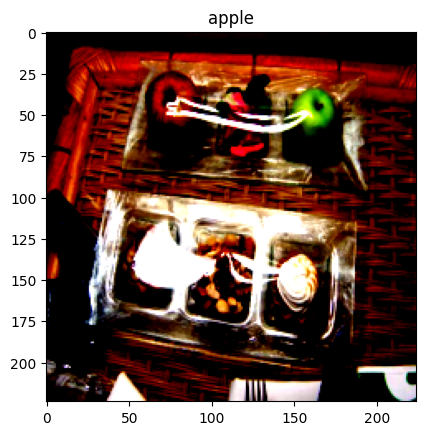

Labels: tensor([[1, 0, 0, 0, 0, 0]])


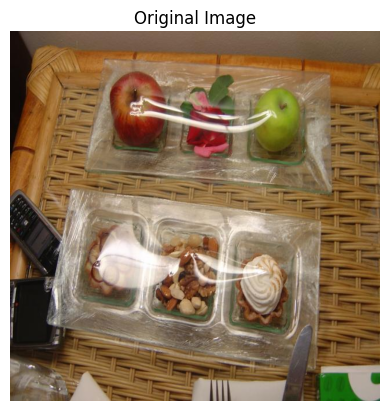

In [6]:
for i, data in enumerate(val_dataset):
    images, labels = data[0], data[1]
    class_index = torch.argmax(labels[0])  # Get index of the first non-zero label
    class_name = val_dataset.class_names[class_index.item()]  # Convert index to class name
    plt.title(class_name)
    plt.imshow(np.transpose(images.numpy(), (1, 2, 0)))  # Transpose the image to (240, 240, 3)
    plt.show()
    # Obtain the path of the plotted image
    image_path = val_dataset.get_image_path(i)
    # Read the original image using OpenCV
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Plot the original image
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis('off')
    
    # Obtain the labels of the plotted image
    image_labels = train_dataset.get_labels(i)
    print("Labels:", image_labels)
    break

Check image shape

In [7]:
images.shape

torch.Size([3, 224, 224])

### Initialize pre-trained model

In [8]:
from torch import nn, optim
from torchvision import models

# Initialize pre-trained model
pretrained_model = models.resnet50(pretrained=True)

/Users/catarina/Desktop/DataScience/DataScienceProjects/FruitsDetection/fruits-env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/catarina/Desktop/DataScience/DataScienceProjects/FruitsDetection/fruits-env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Check the model

In [9]:
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Check model's layers

In [10]:
# Iterate through the named modules and print each one
for name, layer in pretrained_model.named_modules():
    display(name, layer)

''

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

'conv1'

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

'bn1'

BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'relu'

ReLU(inplace=True)

'maxpool'

MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

'layer1'

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, ke

'layer1.0'

Bottleneck(
  (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

'layer1.0.conv1'

Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)

'layer1.0.bn1'

BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer1.0.conv2'

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

'layer1.0.bn2'

BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer1.0.conv3'

Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)

'layer1.0.bn3'

BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer1.0.relu'

ReLU(inplace=True)

'layer1.0.downsample'

Sequential(
  (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

'layer1.0.downsample.0'

Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)

'layer1.0.downsample.1'

BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer1.1'

Bottleneck(
  (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

'layer1.1.conv1'

Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)

'layer1.1.bn1'

BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer1.1.conv2'

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

'layer1.1.bn2'

BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer1.1.conv3'

Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)

'layer1.1.bn3'

BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer1.1.relu'

ReLU(inplace=True)

'layer1.2'

Bottleneck(
  (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

'layer1.2.conv1'

Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)

'layer1.2.bn1'

BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer1.2.conv2'

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

'layer1.2.bn2'

BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer1.2.conv3'

Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)

'layer1.2.bn3'

BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer1.2.relu'

ReLU(inplace=True)

'layer2'

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(

'layer2.0'

Bottleneck(
  (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

'layer2.0.conv1'

Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)

'layer2.0.bn1'

BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer2.0.conv2'

Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

'layer2.0.bn2'

BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer2.0.conv3'

Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)

'layer2.0.bn3'

BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer2.0.relu'

ReLU(inplace=True)

'layer2.0.downsample'

Sequential(
  (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

'layer2.0.downsample.0'

Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)

'layer2.0.downsample.1'

BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer2.1'

Bottleneck(
  (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

'layer2.1.conv1'

Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)

'layer2.1.bn1'

BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer2.1.conv2'

Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

'layer2.1.bn2'

BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer2.1.conv3'

Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)

'layer2.1.bn3'

BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer2.1.relu'

ReLU(inplace=True)

'layer2.2'

Bottleneck(
  (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

'layer2.2.conv1'

Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)

'layer2.2.bn1'

BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer2.2.conv2'

Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

'layer2.2.bn2'

BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer2.2.conv3'

Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)

'layer2.2.bn3'

BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer2.2.relu'

ReLU(inplace=True)

'layer2.3'

Bottleneck(
  (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

'layer2.3.conv1'

Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)

'layer2.3.bn1'

BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer2.3.conv2'

Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

'layer2.3.bn2'

BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer2.3.conv3'

Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)

'layer2.3.bn3'

BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer2.3.relu'

ReLU(inplace=True)

'layer3'

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Co

'layer3.0'

Bottleneck(
  (conv1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

'layer3.0.conv1'

Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)

'layer3.0.bn1'

BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer3.0.conv2'

Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

'layer3.0.bn2'

BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer3.0.conv3'

Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)

'layer3.0.bn3'

BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer3.0.relu'

ReLU(inplace=True)

'layer3.0.downsample'

Sequential(
  (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False)
  (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

'layer3.0.downsample.0'

Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False)

'layer3.0.downsample.1'

BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer3.1'

Bottleneck(
  (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

'layer3.1.conv1'

Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)

'layer3.1.bn1'

BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer3.1.conv2'

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

'layer3.1.bn2'

BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer3.1.conv3'

Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)

'layer3.1.bn3'

BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer3.1.relu'

ReLU(inplace=True)

'layer3.2'

Bottleneck(
  (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

'layer3.2.conv1'

Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)

'layer3.2.bn1'

BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer3.2.conv2'

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

'layer3.2.bn2'

BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer3.2.conv3'

Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)

'layer3.2.bn3'

BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer3.2.relu'

ReLU(inplace=True)

'layer3.3'

Bottleneck(
  (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

'layer3.3.conv1'

Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)

'layer3.3.bn1'

BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer3.3.conv2'

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

'layer3.3.bn2'

BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer3.3.conv3'

Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)

'layer3.3.bn3'

BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer3.3.relu'

ReLU(inplace=True)

'layer3.4'

Bottleneck(
  (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

'layer3.4.conv1'

Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)

'layer3.4.bn1'

BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer3.4.conv2'

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

'layer3.4.bn2'

BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer3.4.conv3'

Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)

'layer3.4.bn3'

BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer3.4.relu'

ReLU(inplace=True)

'layer3.5'

Bottleneck(
  (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

'layer3.5.conv1'

Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)

'layer3.5.bn1'

BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer3.5.conv2'

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

'layer3.5.bn2'

BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer3.5.conv3'

Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)

'layer3.5.bn3'

BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer3.5.relu'

ReLU(inplace=True)

'layer4'

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): 

'layer4.0'

Bottleneck(
  (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

'layer4.0.conv1'

Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)

'layer4.0.bn1'

BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer4.0.conv2'

Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

'layer4.0.bn2'

BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer4.0.conv3'

Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)

'layer4.0.bn3'

BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer4.0.relu'

ReLU(inplace=True)

'layer4.0.downsample'

Sequential(
  (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
  (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

'layer4.0.downsample.0'

Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)

'layer4.0.downsample.1'

BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer4.1'

Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

'layer4.1.conv1'

Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)

'layer4.1.bn1'

BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer4.1.conv2'

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

'layer4.1.bn2'

BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer4.1.conv3'

Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)

'layer4.1.bn3'

BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer4.1.relu'

ReLU(inplace=True)

'layer4.2'

Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

'layer4.2.conv1'

Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)

'layer4.2.bn1'

BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer4.2.conv2'

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

'layer4.2.bn2'

BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer4.2.conv3'

Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)

'layer4.2.bn3'

BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

'layer4.2.relu'

ReLU(inplace=True)

'avgpool'

AdaptiveAvgPool2d(output_size=(1, 1))

'fc'

Linear(in_features=2048, out_features=1000, bias=True)

Find the last layers

In [11]:
# Get the last layer of the model
last_layer_name, last_layer = list(pretrained_model.named_children())[-1]
# Print information about the last layer
print("Last Layer Name:", last_layer_name)
print("Last Layer:", last_layer)

Last Layer Name: fc
Last Layer: Linear(in_features=2048, out_features=1000, bias=True)


### Modify the last layer of the pretrained model for multi-label classification

In [12]:
num_classes = 6

pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, num_classes)

# Freeze the parameters of the pre-trained layers
for param in pretrained_model.parameters():
    param.requires_grad = False

# Unfreeze the parameters of the last few layers for fine-tuning
for param in pretrained_model.layer4.parameters():
    param.requires_grad = True

last_layer_name, last_layer = list(pretrained_model.layer4())
print("New last layer:", last_layer)

last_layer_name, last_layer = list(pretrained_model.named_children())[-1]
print("New last layer:", last_layer)

New last layer: Linear(in_features=2048, out_features=6, bias=True)
New last layer: Linear(in_features=2048, out_features=6, bias=True)


### Fine tune the model

In [13]:
from torch.nn import BCEWithLogitsLoss
import torch.optim as optim

# Define loss function (Binary Cross Entropy Loss in this case, for multi-label classification)
criterion = BCEWithLogitsLoss()

# Define optimizer
optimizer = optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9)

# Training loop
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model.to(device)

train_losses = []  # To store the losses for plotting
best_val_loss = float('inf')  # Initialize with a very large value

# Train the model
for epoch in range(num_epochs):
    
    # Train the model on the training set
    pretrained_model.train()
    
    # Initialize the training loss accumulator to zero
    training_loss = 0.0
    
    for i, (image, labels) in enumerate(train_dataset):
        # Prepare data and send it to the proper device
        image = image.unsqueeze(0).to(device)
        labels = labels.float().to(device)

        # Clear the gradients of all optimized parameters
        optimizer.zero_grad()

        # Forward pass: obtain model predictions for the input data
        outputs = pretrained_model(image)

        # Compute the loss between the model predictions and the true labels
        loss = criterion(outputs, labels)

        # Backward pass: compute gradients of the loss with respect to model parameters
        loss.backward()

        # Update model parameters using the computed gradients and the optimizer
        optimizer.step()

        # Update the training loss
        training_loss += loss.item()

    # Calculate average training loss
    train_loss = training_loss / len(train_dataset)
    train_losses.append(train_loss)

    # Evaluate the model on the validation set
    pretrained_model.eval()
    val_loss = 0.0
    correct_preds = 0
    total_samples = 0
    with torch.no_grad():
        for image, labels in val_dataset:
            # Prepare data and send it to the proper device
            image = image.unsqueeze(0).to(device)
            labels = labels.float().to(device)

            # Forward pass: obtain model predictions for the input data
            outputs = pretrained_model(image)

            # Compute the loss between the model predictions and the true labels
            loss = criterion(outputs, labels)

            # Update the validation loss
            val_loss += loss.item()

            # Round up and down to either 1 or 0
            predicted = torch.round(outputs)
            total_samples += labels.size(0)
            # Calculate how many images were correctly classified
            correct_preds += torch.sum(torch.all(torch.eq(predicted, labels), dim=1)).item()

    # Calculate validation loss
    val_loss /= len(val_dataset)

    # Calculate validation accuracy
    val_acc = correct_preds / total_samples * 100

    # Print validation loss and accuracy
    print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {train_loss:.4f}  Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    # Save the model if it performs better on validation set
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(pretrained_model.state_dict(), f'model/train/best_model_epoch_{epoch + 1}.pth')

print('Finished Training')

# Plotting the evolution of loss
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evolution of Training Loss')
plt.legend()
plt.show()

Epoch [1/50] Train Loss: 0.5572  Validation Loss: 0.3761, Validation Accuracy: 0.00%
Epoch [2/50] Train Loss: 0.4824  Validation Loss: 0.4035, Validation Accuracy: 0.00%
Epoch [3/50] Train Loss: 0.4076  Validation Loss: 0.4456, Validation Accuracy: 0.00%
Epoch [4/50] Train Loss: 0.3877  Validation Loss: 0.4623, Validation Accuracy: 0.00%
Epoch [5/50] Train Loss: 0.3948  Validation Loss: 0.4514, Validation Accuracy: 0.00%
Epoch [6/50] Train Loss: 0.3738  Validation Loss: 0.4549, Validation Accuracy: 0.00%
Epoch [7/50] Train Loss: 0.3903  Validation Loss: 0.4941, Validation Accuracy: 0.00%
Epoch [8/50] Train Loss: 0.3714  Validation Loss: 0.4598, Validation Accuracy: 0.00%
Epoch [9/50] Train Loss: 0.3885  Validation Loss: 0.4896, Validation Accuracy: 0.00%
Epoch [10/50] Train Loss: 0.3948  Validation Loss: 0.5222, Validation Accuracy: 0.00%
Epoch [11/50] Train Loss: 0.3793  Validation Loss: 0.4971, Validation Accuracy: 0.00%
Epoch [12/50] Train Loss: 0.3841  Validation Loss: 0.4637, Vali